In [24]:
# Import libraries and modules
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


# Webscraping

## Web Scraping and Page Parsing Function

In this project, we are performing web scraping to extract information from a webpage. The function defined below fetches and parses the content of a specified webpage by sending a request to the URL. The request includes headers to mimic a standard browser request. Once the page is retrieved, the function checks if the page is accessible by verifying the response status code. If the status code is 200 (successful), it proceeds to parse the content using the BeautifulSoup library. If the page is not accessible, it returns an error message.

The below function checks if a webpage is accessible and returns its content if the request is successful. If the page cannot be accessed, it returns an error message.

In [25]:

# Define the function to fetch and parse the webpage
def getParsedWebpage(url):
    """
    Fetch and parse a webpage while handling access errors.

    Parameters:
        url (str): The URL of the webpage to fetch.

    Returns:
        BeautifulSoup object or str: Parsed webpage content or 'error' if the request fails.
    """
    # Set headers to mimic a browser request
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/93.0",
        "Upgrade-Insecure-Requests": "1",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8",
        "DNT": "1"
    }

    try:
        # Send the GET request to the URL
        response = requests.get(url, headers=headers)
        
        # Check if the page is accessible (status code 200 indicates success)
        if response.status_code != 200:
            print(f"Failed to fetch the webpage. Status code: {response.status_code}")
            return 'error'  # Return 'error' if the page is not accessible
        else:
            print("Webpage fetched successfully!")
            # Parse the content of the webpage
            return BeautifulSoup(response.content, 'html.parser')
    except requests.exceptions.RequestException as e:
        # If there was an issue with the request
        print(f"An error occurred: {e}")
        return 'error'

# Example usage
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_age_at_first_marriage'
soup = getParsedWebpage(url)

# Check if the webpage was successfully retrieved
if soup != 'error':
    print("Webpage content parsed successfully.")
else:
    print("Failed to parse the webpage.")


Webpage fetched successfully!
Webpage content parsed successfully.


## Extracting Continent Names and Tables

This section of the code extracts the names of continents and the corresponding tables from the Wikipedia page. It first filters out the headings that correspond to the listed continents, then counts and displays both the continents found and the number of tables associated with them.


In [26]:
# Define the URL of the Wikipedia page you want to scrape
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_age_at_first_marriage'

# Fetch and parse the webpage content
soup = getParsedWebpage(url)

# If the webpage is successfully retrieved, process the data
if soup != 'error':
    # List of continent names to match against
    continents = ['Africa', 'Asia', 'Europe', 'Americas', 'Oceania']

    # Find all the continent headings (h2 with specific text)
    continent_headings = soup.find_all('h2')

    # Filter the h2 elements to only keep those containing a continent name
    filtered_continent_headings = [heading for heading in continent_headings if any(continent in heading.get_text() for continent in continents)]

    # Find the tables (there may be multiple tables for different continents)
    tables = soup.find_all('table', {'class': 'wikitable'})

    # Print the number of continents found and their names
    print(f"Number of Continents Found: {len(filtered_continent_headings)}")
    for heading in filtered_continent_headings:
        print(heading.get_text().strip())

    # Add a blank line for spacing
    print()

    # Print the number of tables found
    print(f"Number of Tables Found: {len(tables)}")
else:
    print("Failed to fetch the webpage.")


Webpage fetched successfully!
Number of Continents Found: 5
Africa
Americas
Asia
Europe
Oceania

Number of Tables Found: 5


## Associating Continent Headings with Tables and Extracting Data

first, we defined the `clean_country_name` function to standardize country names. The function removes unwanted characters, such as content within parentheses or square brackets (e.g., "(more info)" or "[b]"). This ensures the country names are consistent and ready for further analysis.

next, we iterate through the parsed webpage content to associate each continent heading with its corresponding data table. The process begins by initializing two variables: `continent_name`, which stores the current continent's name, and `continent_data`, a dictionary that will store the data for each continent.

The loop processes both headings (`<h2>`) and tables (`<table>`). If an `<h2>` element is encountered, the continent name is extracted from the `id` attribute. When a table is found and a continent name has been identified, the table's rows are processed to extract country data, such as the country's name, age data for men and women, and other related statistics.

The code ensures that only relevant data from rows (skipping headers) is collected and organized into a structured format. Each row in the table corresponds to a country, with its respective data being extracted and stored in a dictionary under the appropriate continent name.

The resulting `continent_data` dictionary holds the data organized by continent, making it easy to access and analyze the information for each region.


In [ ]:
# Function to clean country names
def clean_country_name(country_name):
    # Remove anything in parentheses (like "(more info)") or within square brackets (like "[b]")
    cleaned_name = re.sub(r'\[.*?\]|\(.*?\)', '', country_name)
    return cleaned_name.strip()

# Step 6: Iterate through each continent heading and associate it with the corresponding table
continent_name = None  # This will store the current continent name
continent_data = {}  # Initialize the dictionary to store the data for each continent

# Loop through all the headings and tables
for element in soup.find_all(['h2', 'table']):
    if element.name == 'h2':  # If it's a continent heading (h2)
        continent_name = element.get('id')  # Get the continent name from the 'id' attribute
    elif element.name == 'table' and continent_name:  # If it's a table and we have a continent name
        rows = element.find_all('tr')
        table_data = []

        # Skip the header row (rows[1:])
        for row in rows[1:]:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]

            # Ensure you get the country name and the values for men, women, and average age
            if len(cols) >= 6:  # Ensuring that we have enough columns
                country_data = {
                    'Country': clean_country_name(cols[0]),  # Clean the country name
                    'Men': cols[1],
                    'Women': cols[2],
                    'Average': cols[3],
                    'Age Gap': cols[4],
                    'Age Ratio': cols[5],
                    'Year': cols[6]
                }
                table_data.append(country_data)

        # Store the data in the dictionary under the continent's name
        continent_data[continent_name] = table_data


# Data Cleaning and Preparation

This section focuses on cleaning and preparing the scraped data for further analysis. The code processes the data by converting it into pandas DataFrames for better manipulation. Key cleaning tasks include:

- **Handling Missing or Invalid Data**: The data is first examined for empty entries, which are removed to ensure only relevant information remains.
  
- **Standardizing Numerical Columns**: Specific columns, including 'Men', 'Women', 'Average', 'Age Gap', and 'Age Ratio', are cleaned by removing unwanted characters (e.g., commas) and converted into numeric values. This ensures consistent data types for further analysis.
  
- **Removing Incomplete Entries**: Any rows containing missing values in critical columns ('Men', 'Women', 'Average') are removed to maintain data integrity.

This process prepares the data for reliable analysis by standardizing and cleaning key variables.


In [5]:
# Step 7: Remove any empty DataFrames
continent_data = {continent: data for continent, data in continent_data.items() if data}

# Step 8: Convert the data to a pandas DataFrame for easier manipulation
for continent, data in continent_data.items():
    df = pd.DataFrame(data)
    
    # --- Data Cleaning Starts Here ---
    # Convert 'Men', 'Women', 'Average', 'Age Gap', 'Age Ratio' columns to numeric
    for col in ['Men', 'Women', 'Average', 'Age Gap', 'Age Ratio']:
        if col in df.columns:
            # Remove any unwanted characters like extra spaces or commas from numerical columns
            df[col] = df[col].replace({',': ''}, regex=True)  # Remove commas 
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid entries become NaN

    # Drop rows with missing data in key columns (e.g., 'Men', 'Women', 'Average')
    df = df.dropna(subset=['Men', 'Women', 'Average'], how='any')  # Removing rows with NaN in 'Men', 'Women', or 'Average'
                            

# Data Export and Visualization

After cleaning and preparing the data, it is saved as a CSV file for each continent, ensuring that the results can be easily accessed and used for further analysis. The data is exported using the continent name as part of the file name for easy identification.

Additionally, the first few rows of the cleaned DataFrame are displayed to provide a quick overview of the data and verify the integrity of the cleaning process.


In [19]:
# Iterate over the cleaned data for each continent
for continent, data in continent_data.items():
    # Create a DataFrame for each continent
    df = pd.DataFrame(data)

    # Save the cleaned data for each continent as a CSV file
    csv_filename = f"{continent}_data.csv"
    df.to_csv(csv_filename, index=False)

    # Display the cleaned DataFrame for the current continent (first few rows)
    print(f"Data for {continent}:")
    print(df.head())

    # Add a blank line for spacing between continents
    print()


Data for Africa:
        Country   Men Women Average Age Gap Age Ratio  Year
0       Algeria  33.2  30.8      32     2.4      1.08  2020
1        Angola  26.7  23.4    25.1     3.3      1.14  2009
2         Benin  24.4  19.9    22.2     4.5      1.23  2012
3      Botswana  30.9  26.4    28.7     4.5      1.17  2001
4  Burkina Faso  26.3  19.9    23.1     6.4      1.32  2018

Data for Americas:
               Country   Men Women Average Age Gap Age Ratio  Year
0  Antigua and Barbuda  29.0  25.0      27       4      1.16  2001
1            Argentina  38.8  36.8    37.8       2      1.05  2020
2              Bahamas  30.6  27.0    28.8     3.6      1.13  2010
3             Barbados  35.3  32.9    34.1     2.4      1.07  2000
4               Belize  30.1  28.6    29.4     1.5      1.05  2010

Data for Asia:
       Country   Men Women Average Age Gap Age Ratio  Year
0  Afghanistan  25.6  22.4      24     3.2      1.14  2020
1      Armenia  30.5  27.1    28.8     3.4      1.13  2019
2   Azer

# Filtering and Converting Asia Data for Analysis

The following method filters and processes the data for Asia from the continent_data dictionary, converts it into a pandas DataFrame, and counts the number of countries in Asia, displaying the result. If no data is found, it prints a message indicating this.

In [7]:
# Step 7: Filter out data for Asia
asia_data = continent_data.get('Asia', [])

# Step 8: Convert the Asia data to a pandas DataFrame for easier manipulation
if asia_data:
    df_asia = pd.DataFrame(asia_data)
    
    # Count the number of countries in Asia
    num_countries_asia = len(df_asia)
    print(f"Number of countries in Asia: {num_countries_asia}")  # Display the count with the label
else:
    print("No data found for Asia.")


Number of countries in Asia: 48


## Calculation of Mean Age at First Marriage in Asia

The following section calculates and displays the mean age at first marriage for men, women, and overall in Asia.

In [8]:
# Convert 'Men', 'Women', and 'Average' columns to numeric types
df_asia['Men'] = pd.to_numeric(df_asia['Men'], errors='coerce')
df_asia['Women'] = pd.to_numeric(df_asia['Women'], errors='coerce')
df_asia['Average'] = pd.to_numeric(df_asia['Average'], errors='coerce')

# Calculate the mean for Men, Women, and Average
mean_men = round(df_asia['Men'].mean(), 2) if 'Men' in df_asia.columns else None
mean_women = round(df_asia['Women'].mean(), 2) if 'Women' in df_asia.columns else None
mean_average = round(df_asia['Average'].mean(), 2) if 'Average' in df_asia.columns else None

# Display the mean values
print("\nMean values for Asia:")
print(f"Mean Men: {mean_men}")
print(f"Mean Women: {mean_women}")
print(f"Mean Average: {mean_average}")



Mean values for Asia:
Mean Men: 28.69
Mean Women: 25.68
Mean Average: 27.2


**Mean Age at First Marriage for Asia**

| Metric               | Mean Age (Years) |
|----------------------|------------------|
| **Men**              | 28.69            |
| **Women**            | 25.68            |
| **Average**          | 27.20            |


This table presents the "mean," which refers to the average age at first marriage for men, women, and the overall population in Asia.


## Statistical Measures for Age at First Marriage in Asia

The following statistical measures are computed for the age at first marriage for men and women in Asia:

- Mode
- Median
- Standard Deviation
- Variance


In [9]:

# Mode
mode_men = df_asia['Men'].mode()[0]  # Use [0] to get the first mode if there are multiple
mode_women = df_asia['Women'].mode()[0]

# Median
median_men = df_asia['Men'].median()
median_women = df_asia['Women'].median()

# Standard Deviation
std_dev_men = df_asia['Men'].std()
std_dev_women = df_asia['Women'].std()

# Variance
variance_men = df_asia['Men'].var()
variance_women = df_asia['Women'].var()

# Print results

print(f"Most Frequent Age for Men at First Marriage (Mode): {mode_men}")
print(f"Most Frequent Age for Women at First Marriage (Mode): {mode_women}")
print(f"Median Age for Men at First Marriage (Median): {median_men}")
print(f"Median Age for Women at First Marriage (Median): {median_women}")
print(f"Standard Deviation of Men's Age at First Marriage (Standard Deviation): {std_dev_men:.2f}")
print(f"Standard Deviation of Women's Age at First Marriage (Standard Deviation): {std_dev_women:.2f}")
print(f"Variance in Men's Age at First Marriage (Variance): {variance_men:.2f}")
print(f"Variance in Women's Age at First Marriage (Variance): {variance_women:.2f}")


Most Frequent Age for Men at First Marriage (Mode): 27.2
Most Frequent Age for Women at First Marriage (Mode): 21.0
Median Age for Men at First Marriage (Median): 28.6
Median Age for Women at First Marriage (Median): 25.45
Standard Deviation of Men's Age at First Marriage (Standard Deviation): 3.20
Standard Deviation of Women's Age at First Marriage (Standard Deviation): 3.42
Variance in Men's Age at First Marriage (Variance): 10.23
Variance in Women's Age at First Marriage (Variance): 11.71



**Key Findings**

| Statistic                | Men (Asia)  | Women (Asia) |
|--------------------------|-------------|--------------|
| **Mode**                 | 27.2        | 21.0         |
| **Median**               | 28.6        | 25.45        |
| **Standard Deviation**   | 3.20        | 3.42         |
| **Variance**             | 10.23       | 11.71        |


**Conclusion**

- **Mode**: The mode represents the most frequent age at first marriage. It identifies the age that appears most often for both men and women. The **mode** suggests that men typically marry at a later age than women in the Asian countries studied.

- **Median**: The median is the middle value when the data is ordered. It gives a better representation of the central tendency when data contains outliers or skewed distributions. The **median** values support the mode value, showing that men marry on average at an older age than women.

- **Standard Deviation**: The standard deviation measures how spread out the ages are from the mean. A higher standard deviation indicates greater variability in the ages. 

- **Variance**: Variance is the square of the standard deviation and also indicates the variability in the data.

The **standard deviation** and **variance** provide insight into the consistency of the marriage age, showing a slightly more variable pattern for women across countries.

#### This statistical analysis offers a comprehensive look at marriage age patterns in Asia and reflects broader social trends and cultural differences across countries.


## Visualization of Average Age at First Marriage by Country in Asia

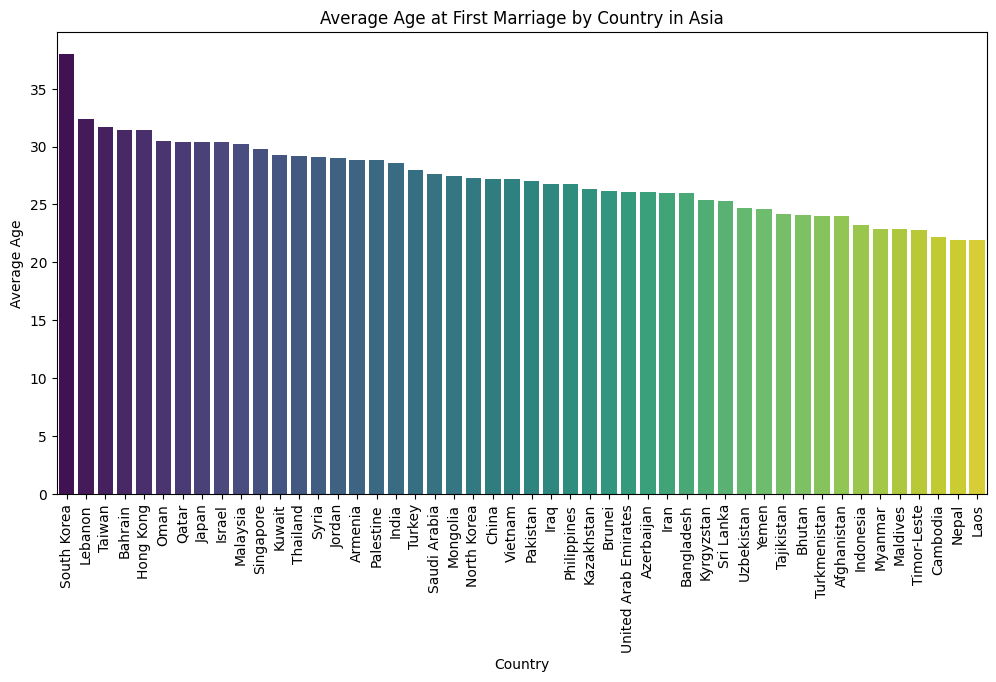

In [10]:
# Sort the dataframe by the existing 'Average' column (average age)
df_asia_sorted = df_asia.sort_values('Average', ascending=False)

# Plotting the average age by country
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Average', data=df_asia_sorted, hue='Country', palette='viridis')

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Title and labels
plt.title('Average Age at First Marriage by Country in Asia')
plt.xlabel('Country')
plt.ylabel('Average Age')

# Show the plot
plt.show()


Now we are visualizing the average age at first marriage for each country in Asia by creating a bar plot. The data is sorted by the 'Average Age' column in descending order to highlight the countries with the highest average age.

**Key Findings: Average Age at First Marriage in Asia**

The bar chart uses a color gradient to visually group countries based on the average age at first marriage:

- **Darker Colors (Purple Shades):**  
  Countries like **South Korea**, **Lebanon**, **Taiwan**, and **Hong Kong** have the highest average ages at first marriage, ranging around **32-38 years old**.

- **Blue to Green Transition:**  
  Countries such as **Malaysia**, **Singapore**,**Thailand** and other countries fall into a slightly younger age group, with averages in the early **30s** and late **20s**.

- **Lighter Colors (Green to Yellow Shades):**  
  Countries like **Afghanistan**, **Cambodia**, and **Nepal** show the youngest average ages, closer to the mid-20s or lower.

The gradient effectively highlights clusters of countries with similar marriage ages, illustrating regional or cultural trends.


1. **Highest Average Age: South Korea (38 years), followed by Lebanon (32.4 years)**  
   - South Korea has the highest average age at first marriage, reflecting a trend toward later marriages, which might be influenced by education, career focus, and changing societal norms.
    Lebanon follows with an average age of 32.4 years, indicating similar patterns of delayed marriage seen in more urbanized and developed regions.

2. **Lowest Average Age: Nepal and Laos (21.9 years)**  
   - Nepal and Laos have the lowest average age at first marriage, highlighting earlier marriage trends driven by cultural and economic factors.

3. **Difference Between Highest and Lowest**  
   - The difference between South Korea (38 years) and Nepal/Laos (21.9 years) is 16.1 years, showcasing significant regional disparities in marriage timing.

This highlights the diverse marriage trends across Asia, influenced by cultural, economic, and regional factors.



## Analysis of Age Gap at First Marriage by Country in Asia 

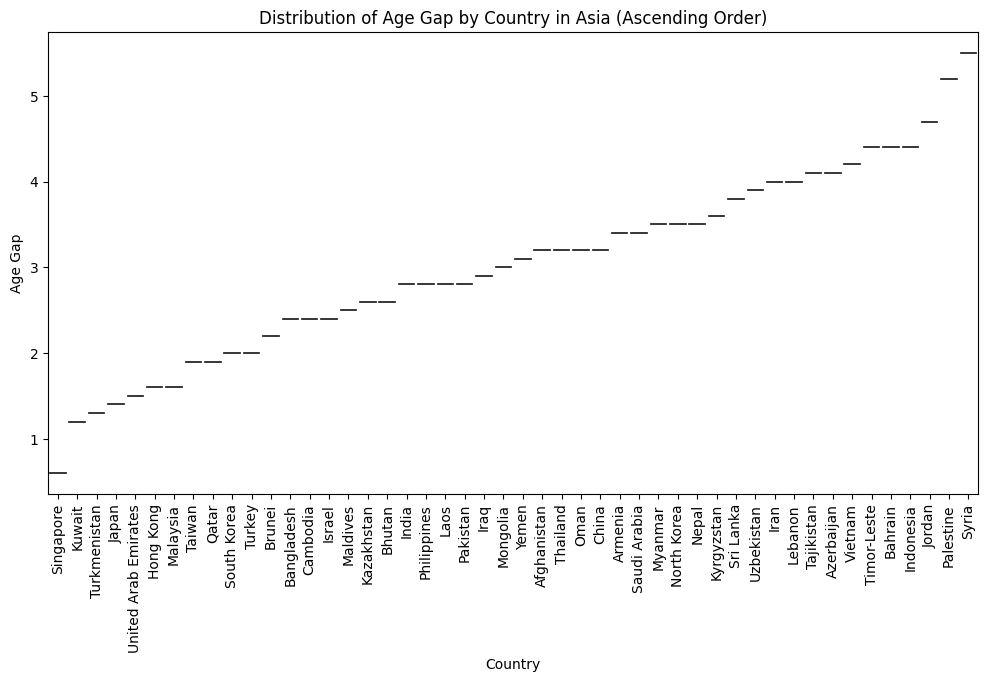

In [11]:
# Convert 'Age Gap' to numeric
df_asia['Age Gap'] = pd.to_numeric(df_asia['Age Gap'], errors='coerce')

# Sort the dataframe by 'Age Gap' in ascending order
df_asia_sorted_gap = df_asia.sort_values('Age Gap', ascending=True)

# Create the violin plot
plt.figure(figsize=(12, 6))

# Create the violin plot with the sorted data
sns.violinplot(x='Country', y='Age Gap', data=df_asia_sorted_gap, hue='Country', palette='viridis', legend=False)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Title and labels
plt.title('Distribution of Age Gap by Country in Asia (Ascending Order)')
plt.xlabel('Country')
plt.ylabel('Age Gap')

# Show the plot
plt.show()




**Key Observations:**
- **Country with the Largest Age Gap:**  
  - **Syria** has the **largest age gap**, exceeding **5 years** which emphasizing the significant disparity in age at first marriage.

- **Country with the Smallest Age Gap:**  
  - **Singapore** exhibits the **smallest age gap**, at less than **1 year**. 

**Countries with the Same Age Gap in Asian Countries**

| Countries                                    | Age Gap   |
|:--------------------------------------------|:---------|
| Malaysia and Hong Kong                       | 1.6 years |
| Qatar and Taiwan                            | 1.9 years |
| South Korea and Turkey                       | 2 years   |
| Bangladesh, Cambodia and Israel             | 2.4 years |
| Bhutan and Kazakhstan                        | 2.6 years |
| India, Philippines, Laos and Pakistan        | 2.8 years |
| Afghanistan, China, Oman and Thailand        | 3.2 years |
| Armenia and Saudi Arabia                     | 3.4 years |
| Myanmar, North Korea and Nepal              | 3.5 years |
| Iran, Lebanon                                | 4 years   |
| Azerbaijan, Tajikistan                       | 4.1 years |
| Bahrain, Indonesia and Timor Leste           | 4.4 years |





## Scatter Plot of Age Gap vs Average Age at First Marriage by Country in Asia

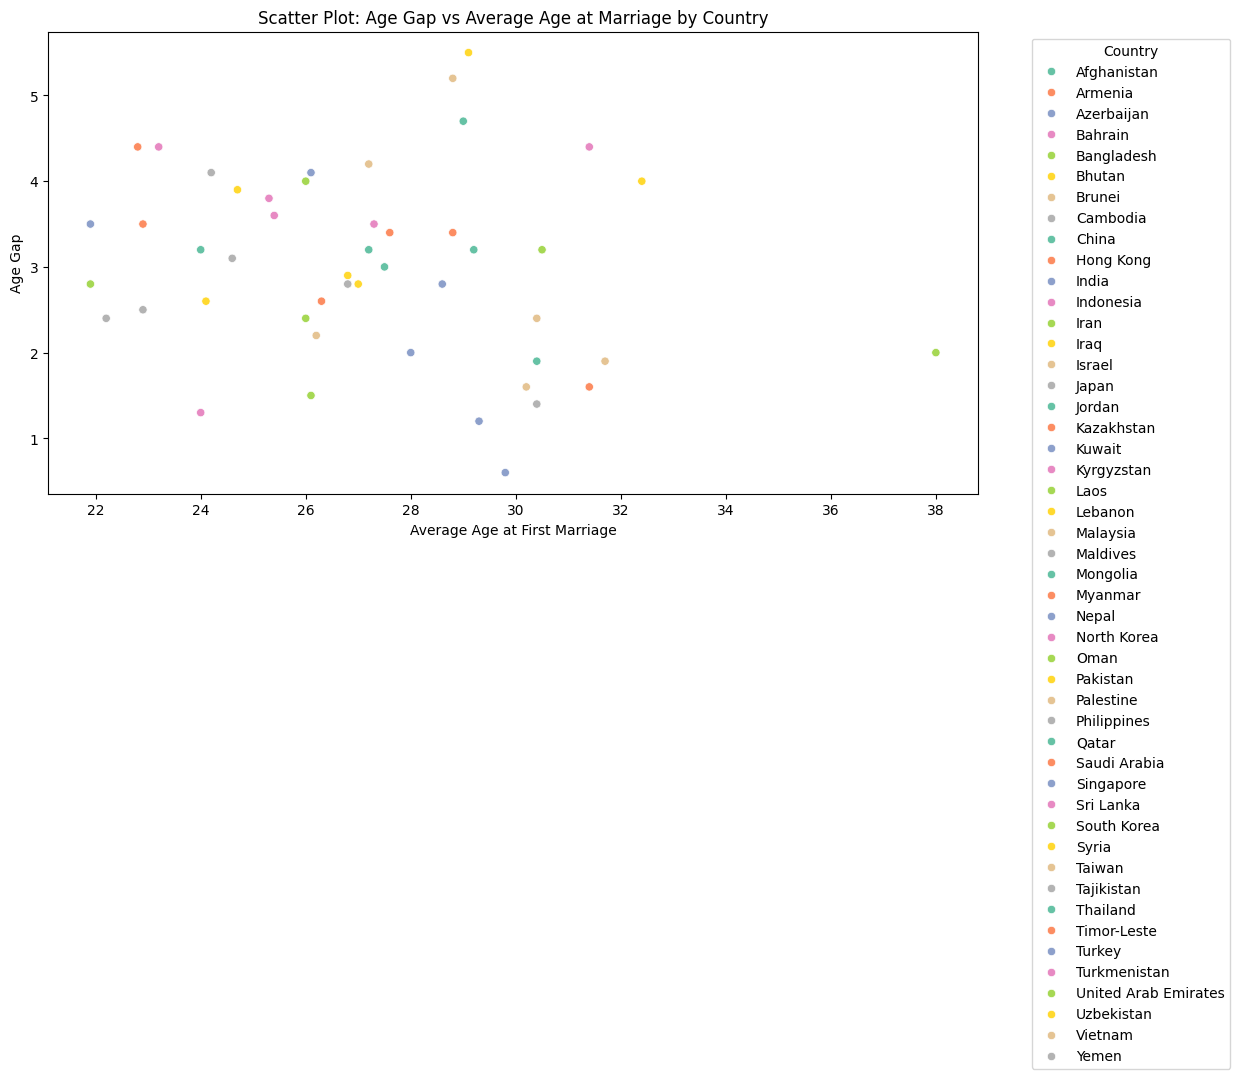

In [12]:

# Scatter plot: Age Gap vs Average Age
plt.figure(figsize=(12, 6))

# Plotting
sns.scatterplot(x='Average', y='Age Gap', data=df_asia, hue='Country', palette='Set2')

# Title and labels
plt.title('Scatter Plot: Age Gap vs Average Age at Marriage by Country')
plt.xlabel('Average Age at First Marriage')
plt.ylabel('Age Gap')

# Show the legend for colors
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


**Analysis of Scatter Plot: Age Gap vs. Average Age at Marriage by Country**

**Observations**

1. **No Clear Trend or Strong Correlation**:
The points are scattered without a definitive upward or downward trend, suggesting a weak or no correlation between the average age at first marriage and the age gap.

2. Variation in Age Gaps:Countries like South Korea and Lebanon, which have higher average ages at first marriage, have varying Age Gaps. This suggests that while some countries may exhibit larger age gaps as the age at marriage increases, others might not, indicating cultural or social differences.Countries like Nepal and Laos with lower average ages at first marriage tend to have a smaller Age Gap, which could reflect different societal structures or marriage norms in those countries.

3. **Clusters**:
A significant number of points cluster around:
     - Average marriage age: **26–30 years**
     - Age gap: **2–4 years**


4. **Outliers**:
Some points deviate significantly from the main clusters:
     - Higher average marriage ages (e.g., above 34 years) with varying age gaps.
     - Unusually large age gaps (e.g., above 5 years).



## Age at First Marriage for Men by Country in Asia

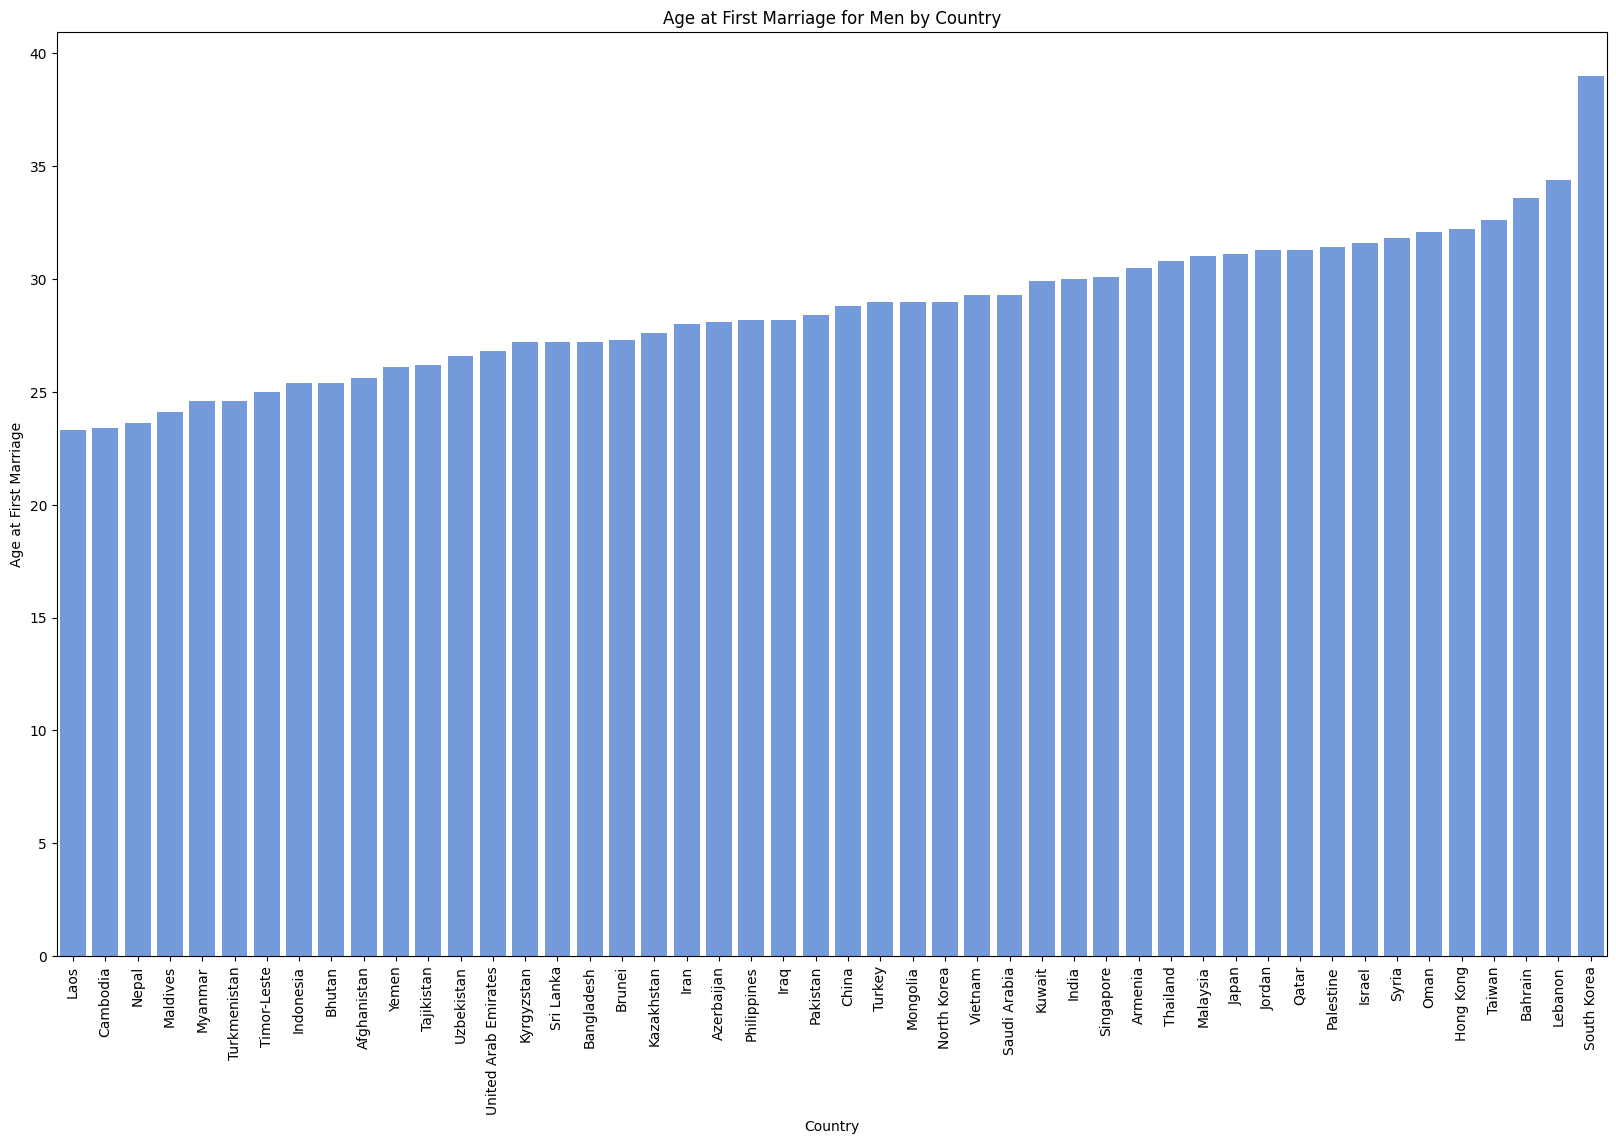

In [13]:
# Filter the data to keep only the 'Men' column
df_men = df_asia_sorted[['Country', 'Men']]

# Sort the data by Age in ascending order
df_men_sorted = df_men.sort_values(by='Men', ascending=True)

# Plotting the bar plot with sorted countries and custom color for Men
plt.figure(figsize=(20, 12))
sns.barplot(x='Country', y='Men', data=df_men_sorted, color='#6495ED')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Title and labels
plt.title('Age at First Marriage for Men by Country')
plt.xlabel('Country')
plt.ylabel('Age at First Marriage')

# Show the plot
plt.show()


**Key Findings:**

- **Lowest Ages**: Countries like **Laos, Cambodia, and Nepal** have the lowest average age for men at first marriage (around 23 and 24 years).

- **Highest Ages (excluding South Korea)**: **Lebanon and Taiwan** show averages above 31 years.

- **Outlier**: **South Korea** has the highest average age at first marriage, reaching **39 years**, significantly higher than other countries.

- **Regional Trends**: East Asian countries (e.g., South Korea, Taiwan, Japan, Hong Kong) generally have older ages at marriage compared to South and Southeast Asia (e.g., Laos, Cambodia, Nepal, Maldives, Bangladesh).


## Age at First Marriage for Women by Country in Asia

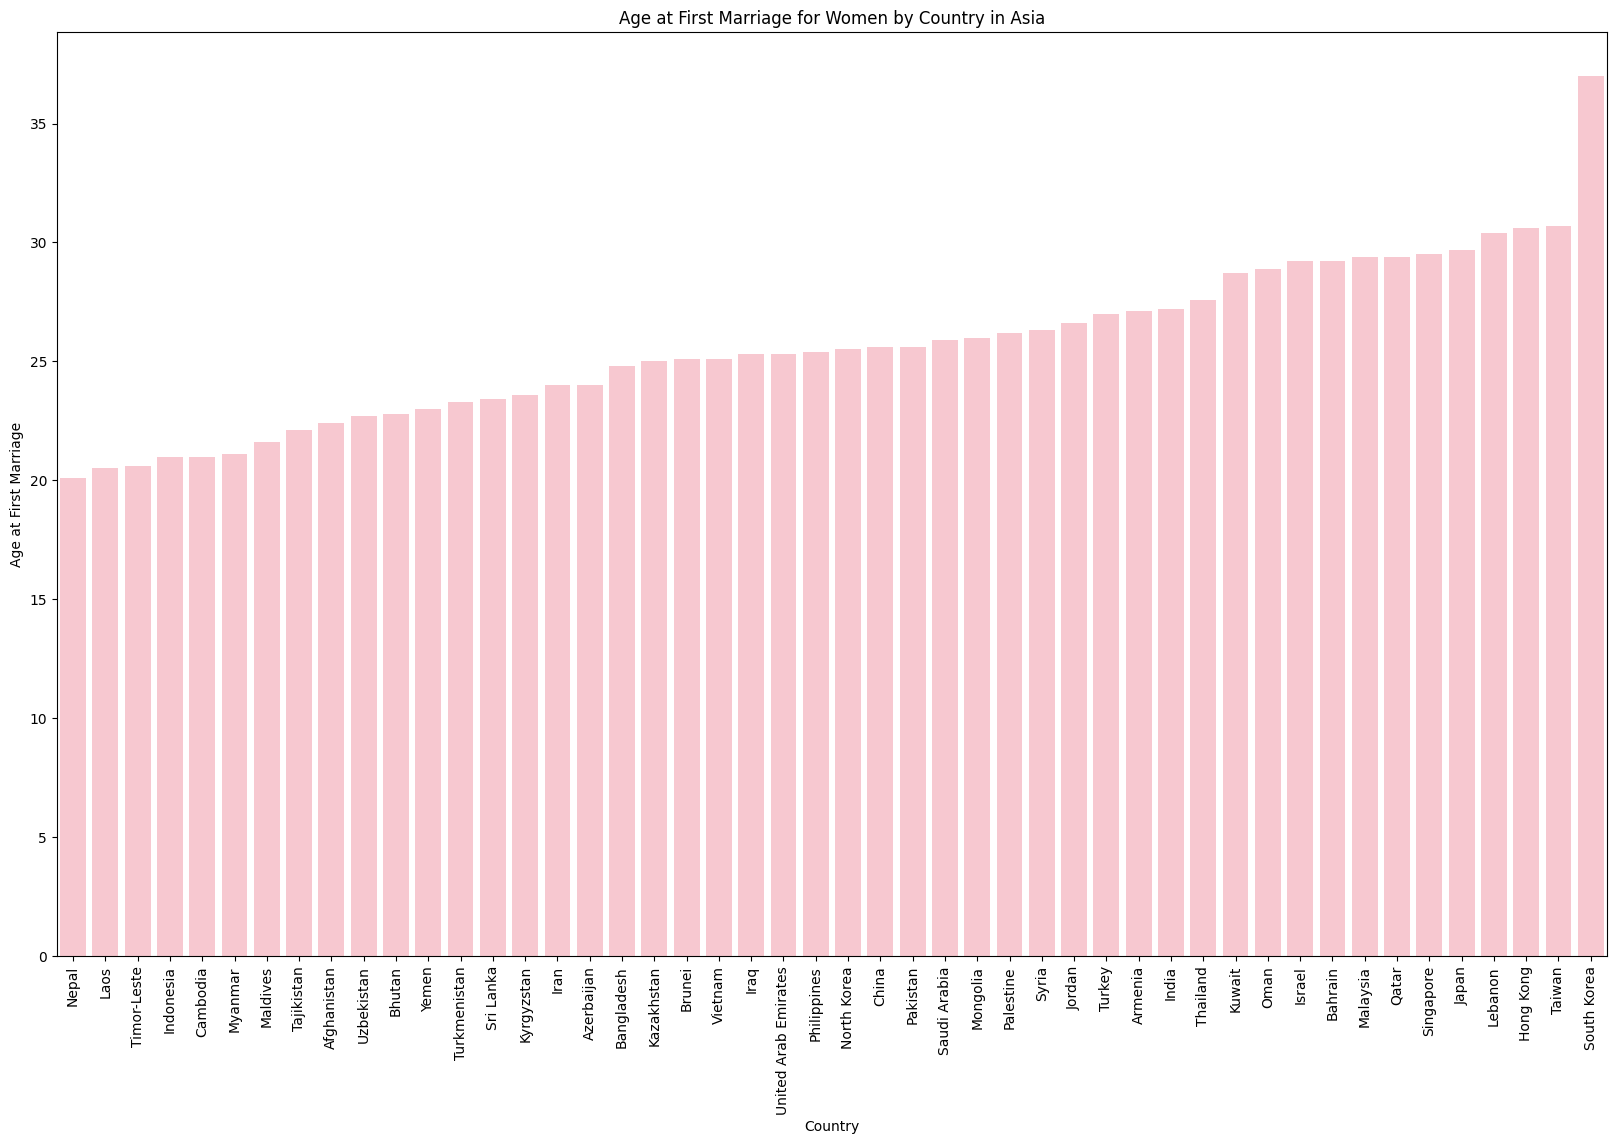

In [14]:
# Filter the data to keep only the 'Women' column
df_women = df_asia_sorted[['Country', 'Women']]

# Sort the data by Age in ascending order
df_women_sorted = df_women.sort_values(by='Women', ascending=True)

# Plotting the bar plot with sorted countries and custom color for Women
plt.figure(figsize=(20, 12))
sns.barplot(x='Country', y='Women', data=df_women_sorted, color='pink')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Title and labels
plt.title('Age at First Marriage for Women by Country in Asia')
plt.xlabel('Country')
plt.ylabel('Age at First Marriage')

# Show the plot
plt.show()


**Key Findings:**

- **Lowest Ages**: Countries like **Nepal, Laos, and Timor-Leste** have the lowest average age at first marriage for women, around **20 years**.

- **Highest Ages (excluding South Korea)**: Countries such as **Lebanon, Taiwan, and Hong Kong** report averages around **30 years**.

- **Outlier**: **South Korea** has the highest average age at first marriage for women, reaching **37 years**, significantly higher than any other country.

- **Regional Trends**: Similar to men, **East Asian countries** (e.g., South Korea, Taiwan, Hong Kong, Japan) tend to have older ages at first marriage for women compared to **South and Southeast Asian countries** (e.g., Nepal, Laos, Cambodia).


# Year of Data Collection for Countries in Asia

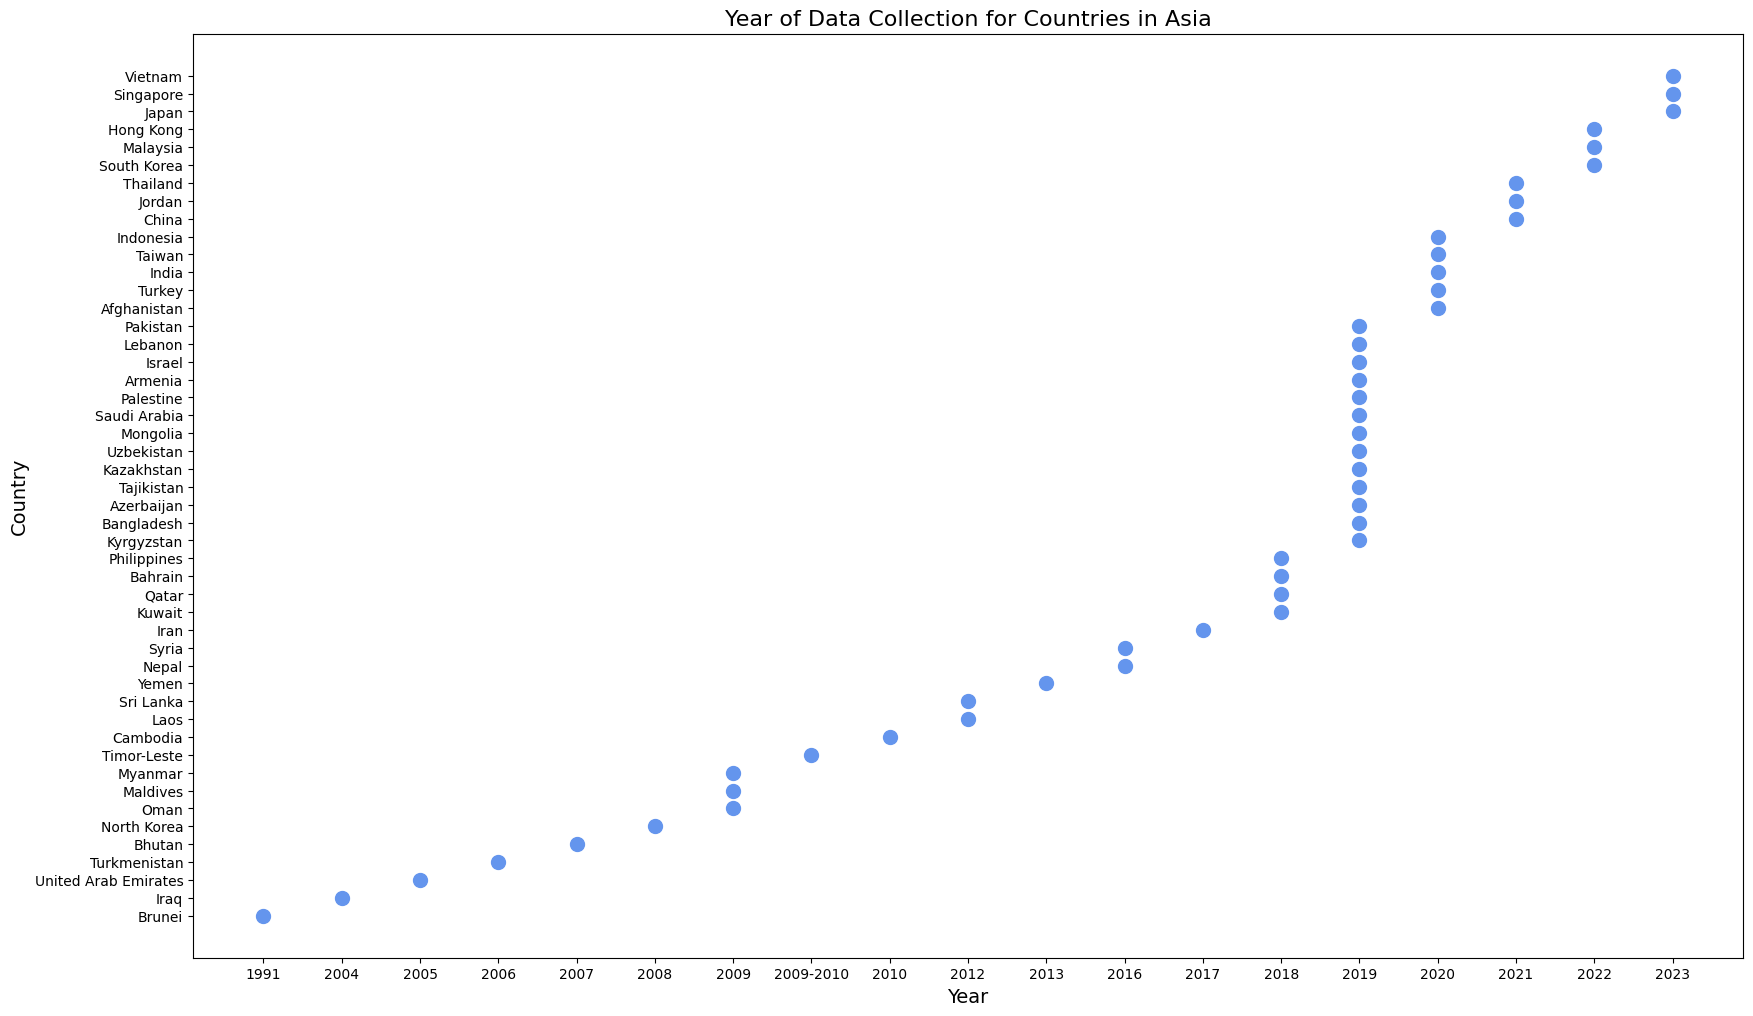

In [15]:

df_asia_sorted = df_asia_sorted.sort_values(by='Year')  # Sorting by Year in ascending order

# Plotting the year of data collection for each country using a scatter plot
plt.figure(figsize=(20, 12))  # Adjusted size for wider and higher plot
plt.scatter(df_asia_sorted['Year'], df_asia_sorted['Country'], color='#6495ED', s=100)  # Slightly darker blue

# Title and labels
plt.title('Year of Data Collection for Countries in Asia', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Country', fontsize=14)

# Show the plot
plt.show()


**Data Considerations for countries in Asia by Age at First Marriage**

While analyzing the data on the, it's important to note a significant challenge:

- **Variation in Data Collection Years**: The years of data collection for each country differ widely, ranging from **1991 (Brunei)** to **2023**. This inconsistency in the time frame means that the data from some countries may not be comparable due to the potential influence of changing societal, economic, and cultural factors over time.

- **Recent Data Dominates**: Although the majority of the countries have data from **2012 onwards**, the earlier years (like 1991 for Brunei) could skew results when comparing global trends. 

- **Impact on Analysis**: This time gap makes it challenging to rely heavily on the results for some countries, as the age at first marriage may have changed significantly due to evolving trends in education, women's rights, and overall social conditions. Therefore, it's crucial to take into account that the data might not fully reflect current realities in some countries, especially those with older data.

This variation should be kept in mind when drawing conclusions or making comparisons across countries.

Here is a table of the countries that share the same data collection year:

| Year       | Countries                                                                                       |
|------------|-------------------------------------------------------------------------------------------------|
| **2009**   | Maldives, Myanmar, Oman, Timor-Leste                                                            |
| **2012**   | Laos, Sri Lanka                                                                                 |
| **2016**   | Nepal, Syria                                                                                   |
| **2018**   | Bahrain, Kuwait, Philippines, Qatar                                                             |
| **2019**   | Armenia, Azerbaijan, Bangladesh, Israel, Kazakhstan, Kyrgyzstan, Lebanon, Mongolia, Pakistan, Palestine, Saudi Arabia, Tajikistan, Uzbekistan |
| **2020**   | Afghanistan, India, Indonesia, Taiwan, Turkey                                                   |
| **2021**   | China, Jordan, Thailand                                                                          |
| **2022**   | Hong Kong, Malaysia, South Korea                                                                 |
| **2023**   | Japan, Singapore, Vietnam                                                                        |



# Comparing Age at First Marriage: Asia vs. Other Continents

Having explored the data on the age at first marriage in Asia, we now expand our analysis to compare Asia with other continents. This comparison will help us understand Asia's position relative to global trends in the age at first marriage.

## Overall Mean Age at First Marriage by Continent

In [16]:
# List of continents to iterate over
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']

# Iterate over each continent and calculate the overall mean age at first marriage
for continent in continents:
    df = pd.DataFrame(continent_data.get(continent, []))

    # Clean the 'Average' column to ensure it is numeric
    df['Average'] = df['Average'].replace({',': ''}, regex=True)  # Remove commas if any
    df['Average'] = pd.to_numeric(df['Average'], errors='coerce')  # Convert to numeric

    # Drop any rows with missing data in the 'Average' column
    df = df.dropna(subset=['Average'], how='any')

    # Calculate the overall mean age at first marriage for the continent
    mean_average = df['Average'].mean()

    print(f"Overall Mean Age at First Marriage for {continent}: {mean_average:.2f} years")


Overall Mean Age at First Marriage for Asia: 27.20 years
Overall Mean Age at First Marriage for Africa: 25.34 years
Overall Mean Age at First Marriage for Americas: 28.90 years
Overall Mean Age at First Marriage for Europe: 31.81 years
Overall Mean Age at First Marriage for Oceania: 26.34 years


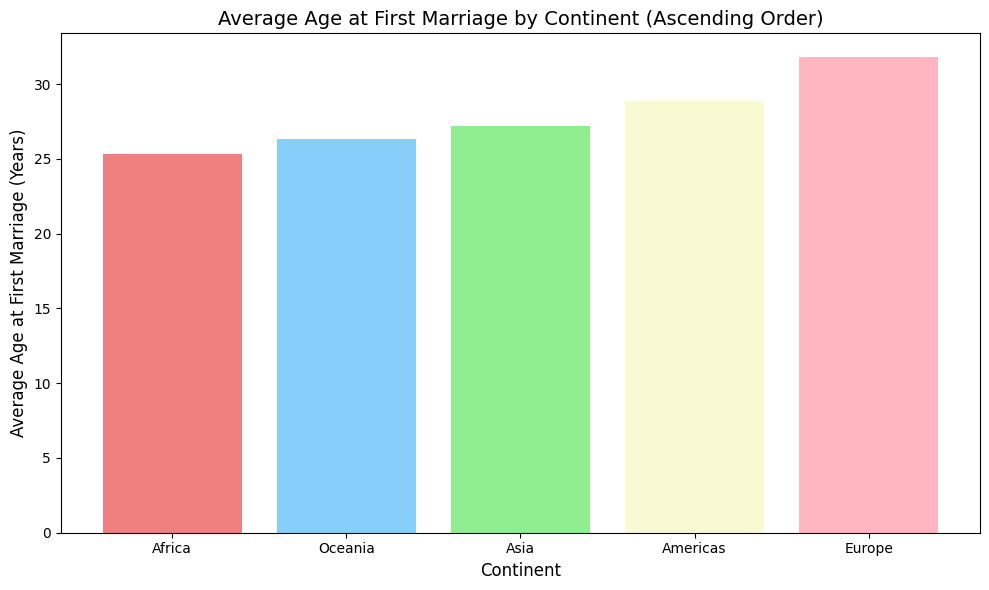

In [17]:

# Data for the bar chart
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']
average_ages = []

# Calculate the overall mean age for each continent
for continent in continents:
    df = pd.DataFrame(continent_data.get(continent, []))

    # Clean the 'Average' column to ensure it is numeric
    df['Average'] = df['Average'].replace({',': ''}, regex=True)  # Remove commas if any
    df['Average'] = pd.to_numeric(df['Average'], errors='coerce')  # Convert to numeric

    # Drop any rows with missing data in the 'Average' column
    df = df.dropna(subset=['Average'], how='any')

    # Calculate the overall mean age at first marriage for the continent
    mean_average = df['Average'].mean()
    average_ages.append(mean_average)

# Sort the data in ascending order
sorted_data = sorted(zip(continents, average_ages), key=lambda x: x[1])
sorted_continents, sorted_average_ages = zip(*sorted_data)

# Colors for the bars
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'lightgoldenrodyellow', 'lightpink']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_continents, sorted_average_ages, color=colors)

# Adding title and labels
plt.title('Average Age at First Marriage by Continent (Ascending Order)', fontsize=14)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Average Age at First Marriage (Years)', fontsize=12)

# Display the bar chart
plt.tight_layout()
plt.show()


**Key Comparison of Asia’s Age at First Marriage with Other Continents**

- Asia ranks 3rd globally in terms of the mean age at first marriage.
- With a mean age of 27.20 years, Asia’s average is lower than Europe (31.81 years) and the Americas (28.86 years) but higher than Africa (25.34 years) and Oceania (26.34 years).
- In summary, Asians marry earlier than Europeans and Americans, but later than Africans and Oceanians.


## Average Age Gap at First Marriage Asia vs. Other Continents

In [18]:
# Data for the continents
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']
average_age_gaps = {}

# Calculate the overall mean age gap for each continent
for continent in continents:
    df = pd.DataFrame(continent_data.get(continent, []))

    # Clean the 'Age Gap' column to ensure it is numeric
    df['Age Gap'] = df['Age Gap'].replace({',': ''}, regex=True)  # Remove commas if any
    df['Age Gap'] = pd.to_numeric(df['Age Gap'], errors='coerce')  # Convert to numeric

    # Drop any rows with missing data in the 'Age Gap' column
    df = df.dropna(subset=['Age Gap'], how='any')

    # Calculate the overall mean age gap for the continent
    mean_age_gap = df['Age Gap'].mean()
    average_age_gaps[continent] = mean_age_gap

# Print the average age gap for each continent
for continent, avg_gap in average_age_gaps.items():
    print(f"Overall Mean Age Gap at First Marriage for {continent}: {avg_gap:.2f} years")


Overall Mean Age Gap at First Marriage for Asia: 3.01 years
Overall Mean Age Gap at First Marriage for Africa: 5.01 years
Overall Mean Age Gap at First Marriage for Americas: 2.88 years
Overall Mean Age Gap at First Marriage for Europe: 2.36 years
Overall Mean Age Gap at First Marriage for Oceania: 2.96 years


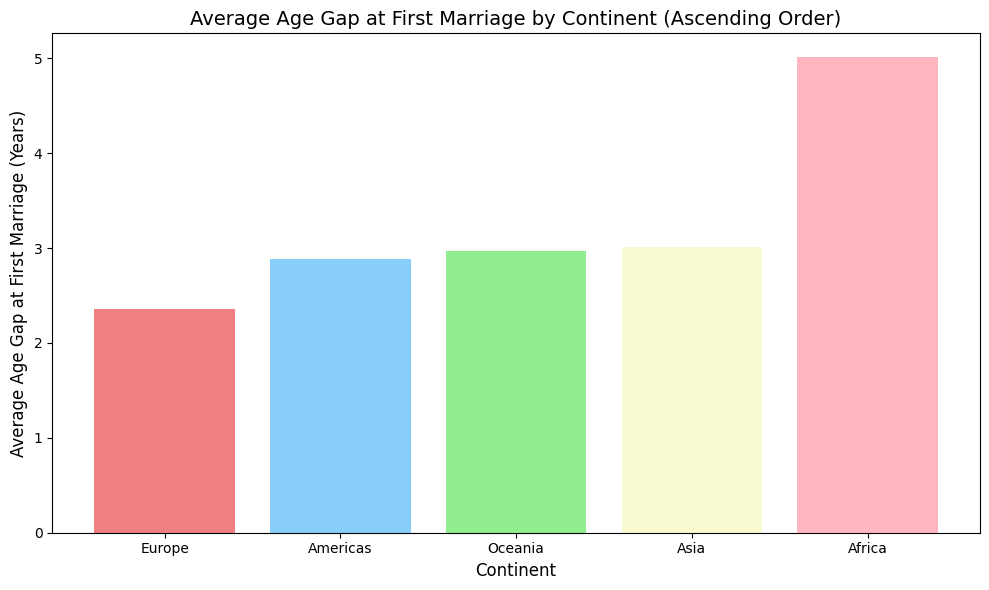

In [19]:


# Sort the data in ascending order
sorted_data_gap = sorted(average_age_gaps.items(), key=lambda x: x[1])
sorted_continents_gap, sorted_average_age_gaps = zip(*sorted_data_gap)

# Colors for the bars
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'lightgoldenrodyellow', 'lightpink']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_continents_gap, sorted_average_age_gaps, color=colors)

# Adding title and labels
plt.title('Average Age Gap at First Marriage by Continent (Ascending Order)', fontsize=14)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Average Age Gap at First Marriage (Years)', fontsize=12)

# Display the bar chart
plt.tight_layout()
plt.show()


**Key Comparison of Asia’s Age Gap at First Marriage with Other Continents:**

- **Asia (3.01 years)** has a **moderate age gap**, larger than **Europe (2.36 years)** and **Americas (2.90 years)**, but smaller than **Africa (5.01 years)**.
- **Africa** has the **largest age gap**, indicating more traditional marriage patterns.
- **Europe** shows a **minimal gap**, suggesting greater gender equality in marriage ages.
- **Americas (2.90 years)** and **Oceania (2.96 years)** have **slightly smaller gaps** than Asia, reflecting a more balanced approach to marriage ages.

In summary, Asia’s age gap is **higher than Europe, the Americas and Oceania**, but **lower than Africa**, positioning it as a middle-ground in global marriage trends.


## Comparison of Average Age and Age Gap at First Marriage by Continent

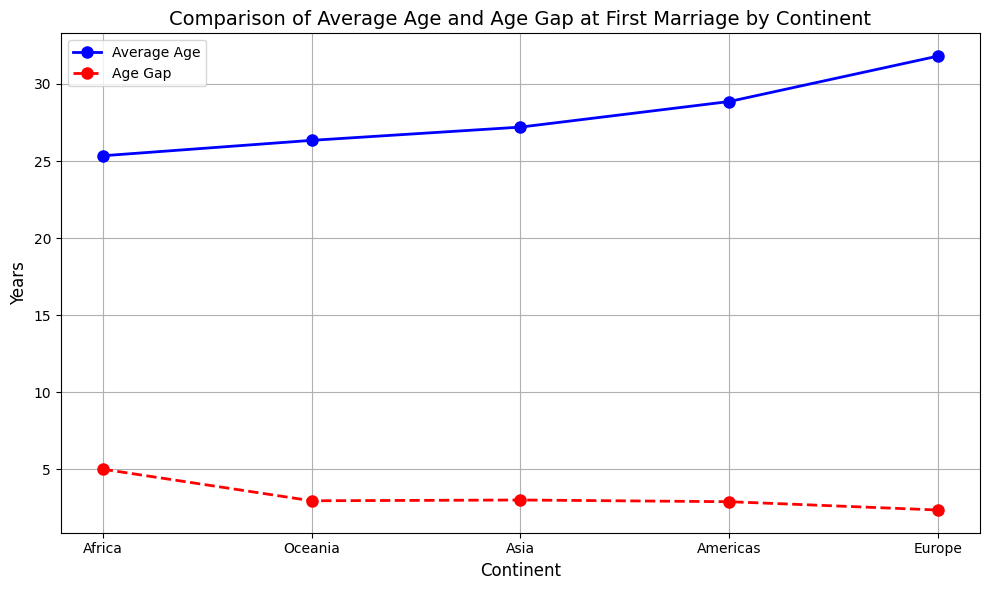

In [20]:
# Data for the line plot
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']
average_ages = [27.20, 25.34, 28.86, 31.81, 26.34]  # Example data for average age
age_gaps = [3.01, 5.01, 2.90, 2.36, 2.96]  # Example data for age gap

# Sorting data based on average age
sorted_data = sorted(zip(continents, average_ages, age_gaps), key=lambda x: x[1])

# Unzip the sorted data
sorted_continents, sorted_average_ages, sorted_age_gaps = zip(*sorted_data)

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot for Average Age
plt.plot(sorted_continents, sorted_average_ages, marker='o', label='Average Age', color='b', linestyle='-', linewidth=2, markersize=8)

# Plot for Age Gap
plt.plot(sorted_continents, sorted_age_gaps, marker='o', label='Age Gap', color='r', linestyle='--', linewidth=2, markersize=8)

# Adding title and labels
plt.title('Comparison of Average Age and Age Gap at First Marriage by Continent', fontsize=14)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Years', fontsize=12)

# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


## Comparison of Average Age at First Marriage for Men and Women Asia vs. Other Continents

In [21]:

# Define the continents
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']
average_men_ages = []
average_women_ages = []

# Loop through each continent and calculate the average age for men and women
for continent in continents:
    df = pd.DataFrame(continent_data.get(continent, []))
    
    # Clean the 'Men' and 'Women' columns to ensure they are numeric
    df['Men'] = df['Men'].replace({',': ''}, regex=True)  # Remove commas if any
    df['Men'] = pd.to_numeric(df['Men'], errors='coerce')  # Convert to numeric
    df['Women'] = df['Women'].replace({',': ''}, regex=True)  # Remove commas if any
    df['Women'] = pd.to_numeric(df['Women'], errors='coerce')  # Convert to numeric
    
    # Drop any rows with missing data in the 'Men' or 'Women' columns
    df = df.dropna(subset=['Men', 'Women'], how='any')
    
    # Calculate the overall mean age for men and women for the continent
    mean_men_age = df['Men'].mean()
    mean_women_age = df['Women'].mean()
    
    average_men_ages.append(mean_men_age)
    average_women_ages.append(mean_women_age)

# Printing out the results for comparison
for continent, men_age, women_age in zip(continents, average_men_ages, average_women_ages):
    print(f"{continent}: Men = {men_age:.2f} years, Women = {women_age:.2f} years")


Asia: Men = 28.69 years, Women = 25.68 years
Africa: Men = 27.83 years, Women = 22.82 years
Americas: Men = 30.33 years, Women = 27.45 years
Europe: Men = 32.97 years, Women = 30.61 years
Oceania: Men = 27.81 years, Women = 24.84 years


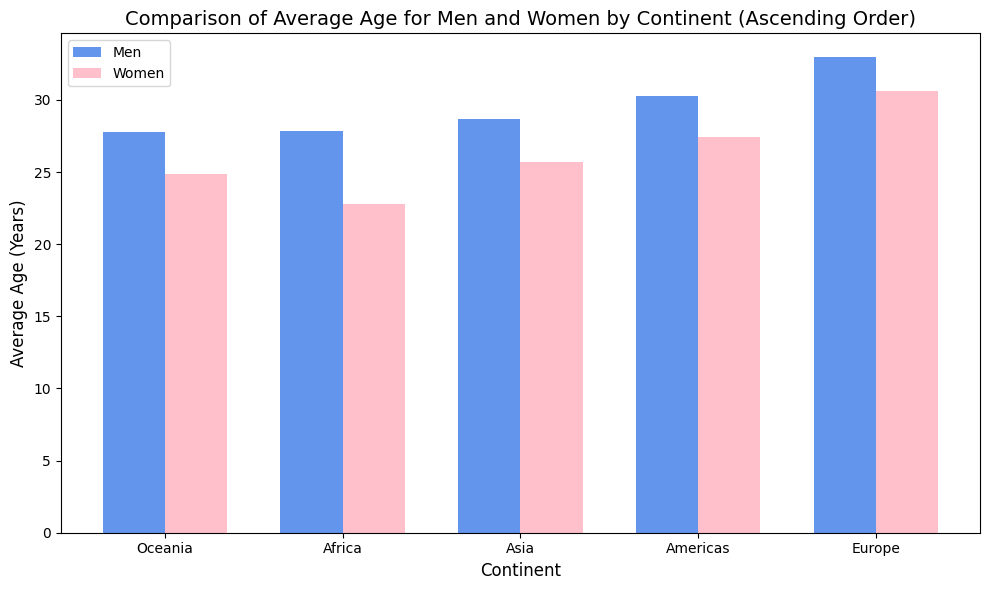

In [22]:


# Actual data from your calculation
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']
average_men_ages = [28.69, 27.83, 30.29, 32.97, 27.81]
average_women_ages = [25.68, 22.82, 27.40, 30.61, 24.84]

# Sort the data based on the average age of men
sorted_data = sorted(zip(continents, average_men_ages, average_women_ages), key=lambda x: x[1])
sorted_continents, sorted_men_ages, sorted_women_ages = zip(*sorted_data)

# Set the positions for the bars
x = np.arange(len(sorted_continents))
width = 0.35  # Width of the bars

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for men and women
rects1 = ax.bar(x - width/2, sorted_men_ages, width, label='Men', color='#6495ED')
rects2 = ax.bar(x + width/2, sorted_women_ages, width, label='Women', color='pink')

# Adding title and labels
ax.set_title('Comparison of Average Age for Men and Women by Continent (Ascending Order)', fontsize=14)
ax.set_xlabel('Continent', fontsize=12)
ax.set_ylabel('Average Age (Years)', fontsize=12)

# Set the x-ticks to match the continents
ax.set_xticks(x)
ax.set_xticklabels(sorted_continents)

# Adding a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


**Analysis of Average Age for Men and Women in Asia:**

- **Asian Men:**
  - The average age for men in Asia is **28.69 years**, which places them **3rd** among the continents, behind Europe (32.97 years) and the Americas (30.29 years), but ahead of Africa (27.83 years) and Oceania (27.81 years).
  - This suggests that Asian men tend to marry at a relatively younger age than those in Europe and the Americas, but older than those in Africa and Oceania. This could indicate a more traditional approach to marriage, with men marrying after they have established themselves, but not as late as in some Western or wealthier regions.

- **Asian Women:**
  - The average age for women in Asia is **25.68 years**, which places them **3rd** as well, behind Europe (30.61 years) and the Americas (27.40 years), but ahead of Africa (22.82 years) and Oceania (24.84 years).
  - Similar to men, women in Asia tend to marry at a younger age than their counterparts in Europe and the Americas, but later than those in Africa. This could reflect regional socio-cultural norms where women marry at an age when they are socially and economically prepared, but still relatively younger compared to Western countries.

- Both **Asian men** and **Asian women** fall in the **middle** range in terms of average age at first marriage when compared to other continents, suggesting that marriage age in Asia is moderate, neither too young nor too late, with cultural variations across countries.


## Comparing the Average Age at Marriage in Asia with Other Countries Across Continents

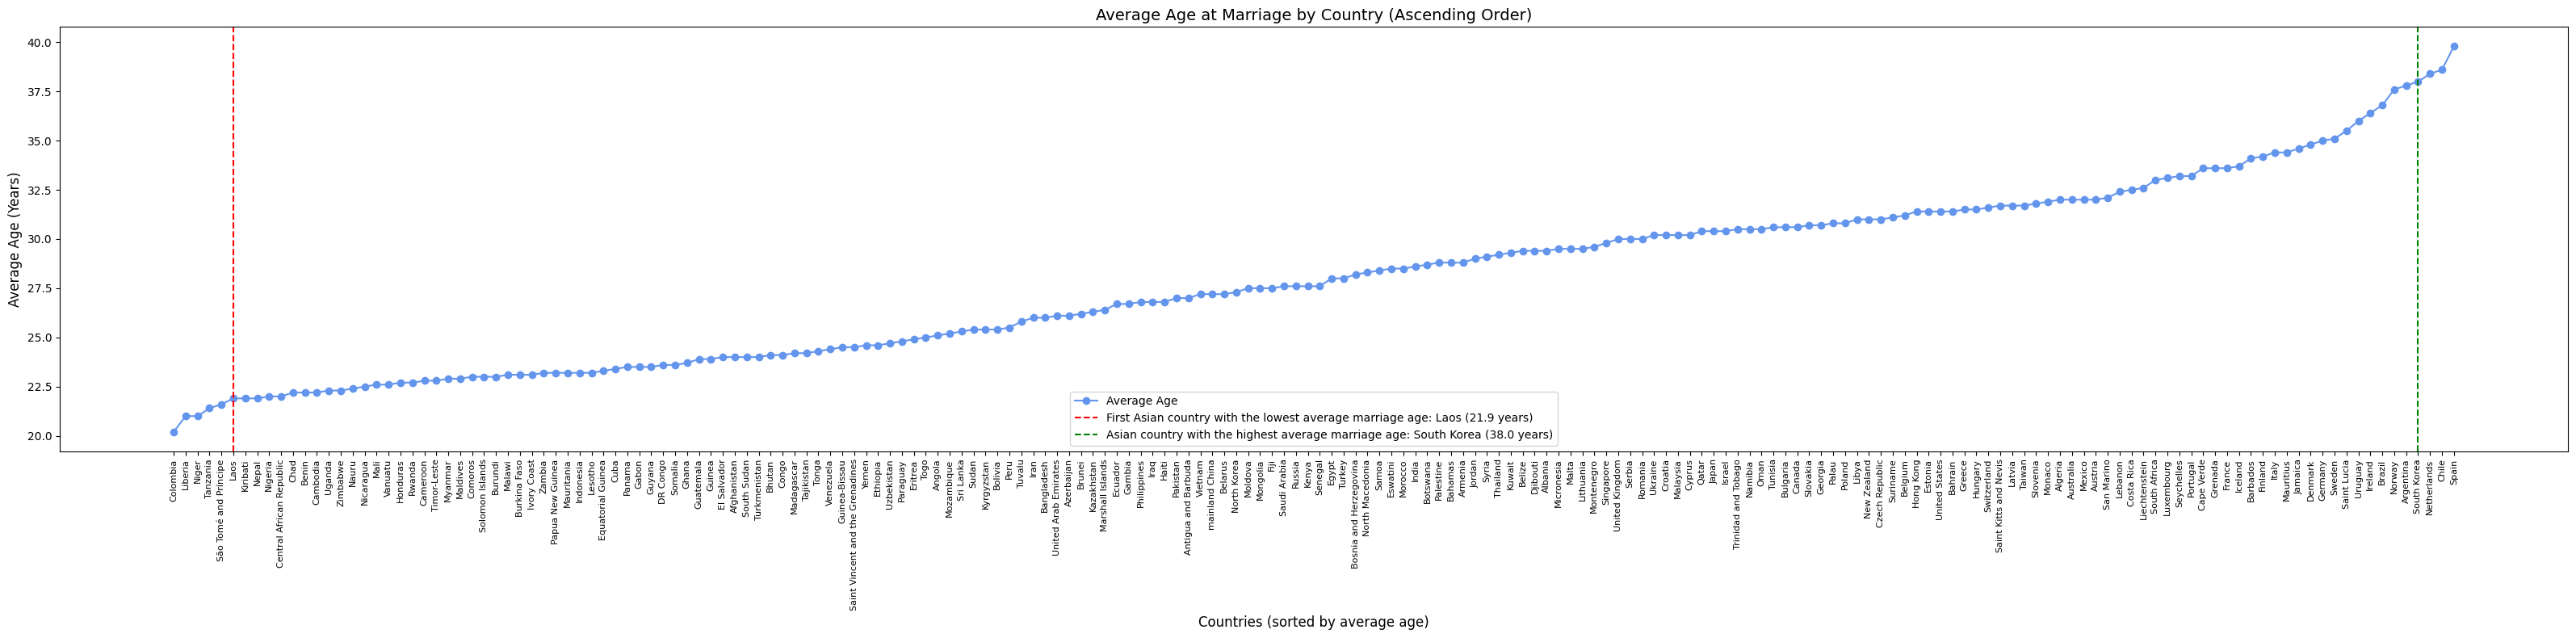

In [23]:


# Assuming `continent_data` is the dictionary containing all the data
all_countries = []
for continent, data in continent_data.items():
    df = pd.DataFrame(data)
    df['Continent'] = continent
    all_countries.append(df)

# Combine all data into one DataFrame
df_all = pd.concat(all_countries, ignore_index=True)

# Clean and prepare the data
df_all['Average'] = df_all['Average'].replace({',': ''}, regex=True).astype(float)
df_all = df_all.dropna(subset=['Average'])

# Sort by average age
df_all_sorted = df_all.sort_values(by='Average').reset_index(drop=True)

# Find the first and highest Asian country
first_asian_country = df_all_sorted[df_all_sorted['Continent'] == 'Asia'].iloc[0]
highest_asian_country = df_all_sorted[df_all_sorted['Continent'] == 'Asia'].iloc[-1]

# Plotting
plt.figure(figsize=(32, 8))
plt.plot(df_all_sorted['Country'], df_all_sorted['Average'], marker='o', color='#6495ED', label='Average Age')
plt.axvline(x=df_all_sorted[df_all_sorted['Country'] == first_asian_country['Country']].index[0],
            color='red', linestyle='--', label=f"First Asian country with the lowest average marriage age: {first_asian_country['Country']} ({first_asian_country['Average']} years)")
plt.axvline(x=df_all_sorted[df_all_sorted['Country'] == highest_asian_country['Country']].index[0],
            color='green', linestyle='--', label=f"Asian country with the highest average marriage age: {highest_asian_country['Country']} ({highest_asian_country['Average']} years)")

# Customize the plot
plt.title('Average Age at Marriage by Country (Ascending Order)', fontsize=14)
plt.xlabel('Countries (sorted by average age)', fontsize=12)
plt.ylabel('Average Age (Years)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


**Key Observations:**


- Highlighted by the **red line**, Laos or Nepal, both(21.9 years) **Asian countries**, rank **6th from the bottom globally** in terms of average age at first marriage.  
- This reflects **younger marriage trends**, potentially due to **cultural norms** or **economic factors** prevalent in parts of Asia.


- Highlighted by the **green line**, South Korea(38 years), another **Asian country**, ranks **4th from the top globally**.  
- This may indicate **delayed marriage trends** influenced by **urbanization**, **career priorities**, or **education** within Asia.

---

**Insights:**

**Diversity in Asia**
- Asian countries exhibit a **broad spectrum of marital ages**, from some of the **youngest** (e.g., Laos or Nepal) to near the **oldest** (e.g., South Korea) globally.  
- This highlights the region’s **vast cultural, social, and economic diversity**.

**Global Context**
- While some Asian countries align with **younger marriage trends** similar to other developing regions, others, like South Korea, reflect **patterns seen in developed nations**.

**The graph underscores Asia’s contrasting marriage trends, shaped by a mix of traditional and modern influences, depending on the country.**


# Year of Data Collection by Continent

In this analysis, we will begin by examining the number of countries in each continent, along with how many of these countries have collected data after 2018. Since the data for each country is collected in different years, this step is essential in identifying any trends and providing context for the data analysis. By understanding the distribut


## Number of Countries in Each Continent

In [24]:
# List of continents to iterate over
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']

# Iterate over each continent and calculate the number of countries
for continent in continents:
    df = pd.DataFrame(continent_data.get(continent, []))

    # Ensure the 'Country' column is present and clean it
    if 'Country' in df.columns:
        country_count = df['Country'].nunique()  # Count the unique number of countries
        print(f"Number of countries in {continent}: {country_count}")
    else:
        print(f"No data found for {continent}")


Number of countries in Asia: 48
Number of countries in Africa: 53
Number of countries in Americas: 33
Number of countries in Europe: 44
Number of countries in Oceania: 14


## Number of Countries with Data Collected After 2018 by Continent


In [25]:
# List of continents to iterate over
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']

# Iterate over each continent and calculate the number of countries with data after 2018
for continent in continents:
    df = pd.DataFrame(continent_data.get(continent, []))

    # Ensure the 'Country' and 'Year' columns are present and clean them
    if 'Country' in df.columns and 'Year' in df.columns:
        # Convert 'Year' to numeric, forcing errors to NaN
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

        # Filter the data to only include rows where 'Year' > 2018
        df_after_2018 = df[df['Year'] > 2018]

        # Count the unique number of countries with data after 2018
        country_count_after_2018 = df_after_2018['Country'].nunique()

        print(f"Number of countries in {continent} with data after 2018: {country_count_after_2018}")
    else:
        print(f"No data found for {continent}")


Number of countries in Asia with data after 2018: 27
Number of countries in Africa with data after 2018: 16
Number of countries in Americas with data after 2018: 11
Number of countries in Europe with data after 2018: 36
Number of countries in Oceania with data after 2018: 6


## Percentage of Countries with Data Collected After 2018 by Continent


In [26]:
# List of continents to iterate over
continents = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']

# Iterate over each continent and calculate the percentage of countries with data after 2018
for continent in continents:
    df = pd.DataFrame(continent_data.get(continent, []))

    # Ensure the 'Country' and 'Year' columns are present and clean them
    if 'Country' in df.columns and 'Year' in df.columns:
        # Convert 'Year' to numeric, forcing errors to NaN
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

        # Count the total number of countries in the continent
        total_countries = df['Country'].nunique()

        # Filter the data to only include rows where 'Year' > 2018
        df_after_2018 = df[df['Year'] > 2018]

        # Count the unique number of countries with data after 2018
        country_count_after_2018 = df_after_2018['Country'].nunique()

        # Calculate the percentage
        if total_countries > 0:
            percentage_after_2018 = (country_count_after_2018 / total_countries) * 100
        else:
            percentage_after_2018 = 0

        print(f"Percentage of countries in {continent} with data after 2018: {percentage_after_2018:.2f}%")
    else:
        print(f"No data found for {continent}")


Percentage of countries in Asia with data after 2018: 56.25%
Percentage of countries in Africa with data after 2018: 30.19%
Percentage of countries in Americas with data after 2018: 33.33%
Percentage of countries in Europe with data after 2018: 81.82%
Percentage of countries in Oceania with data after 2018: 42.86%


## Year of Data Collection for Each Continent: Scatter Plot Visualization


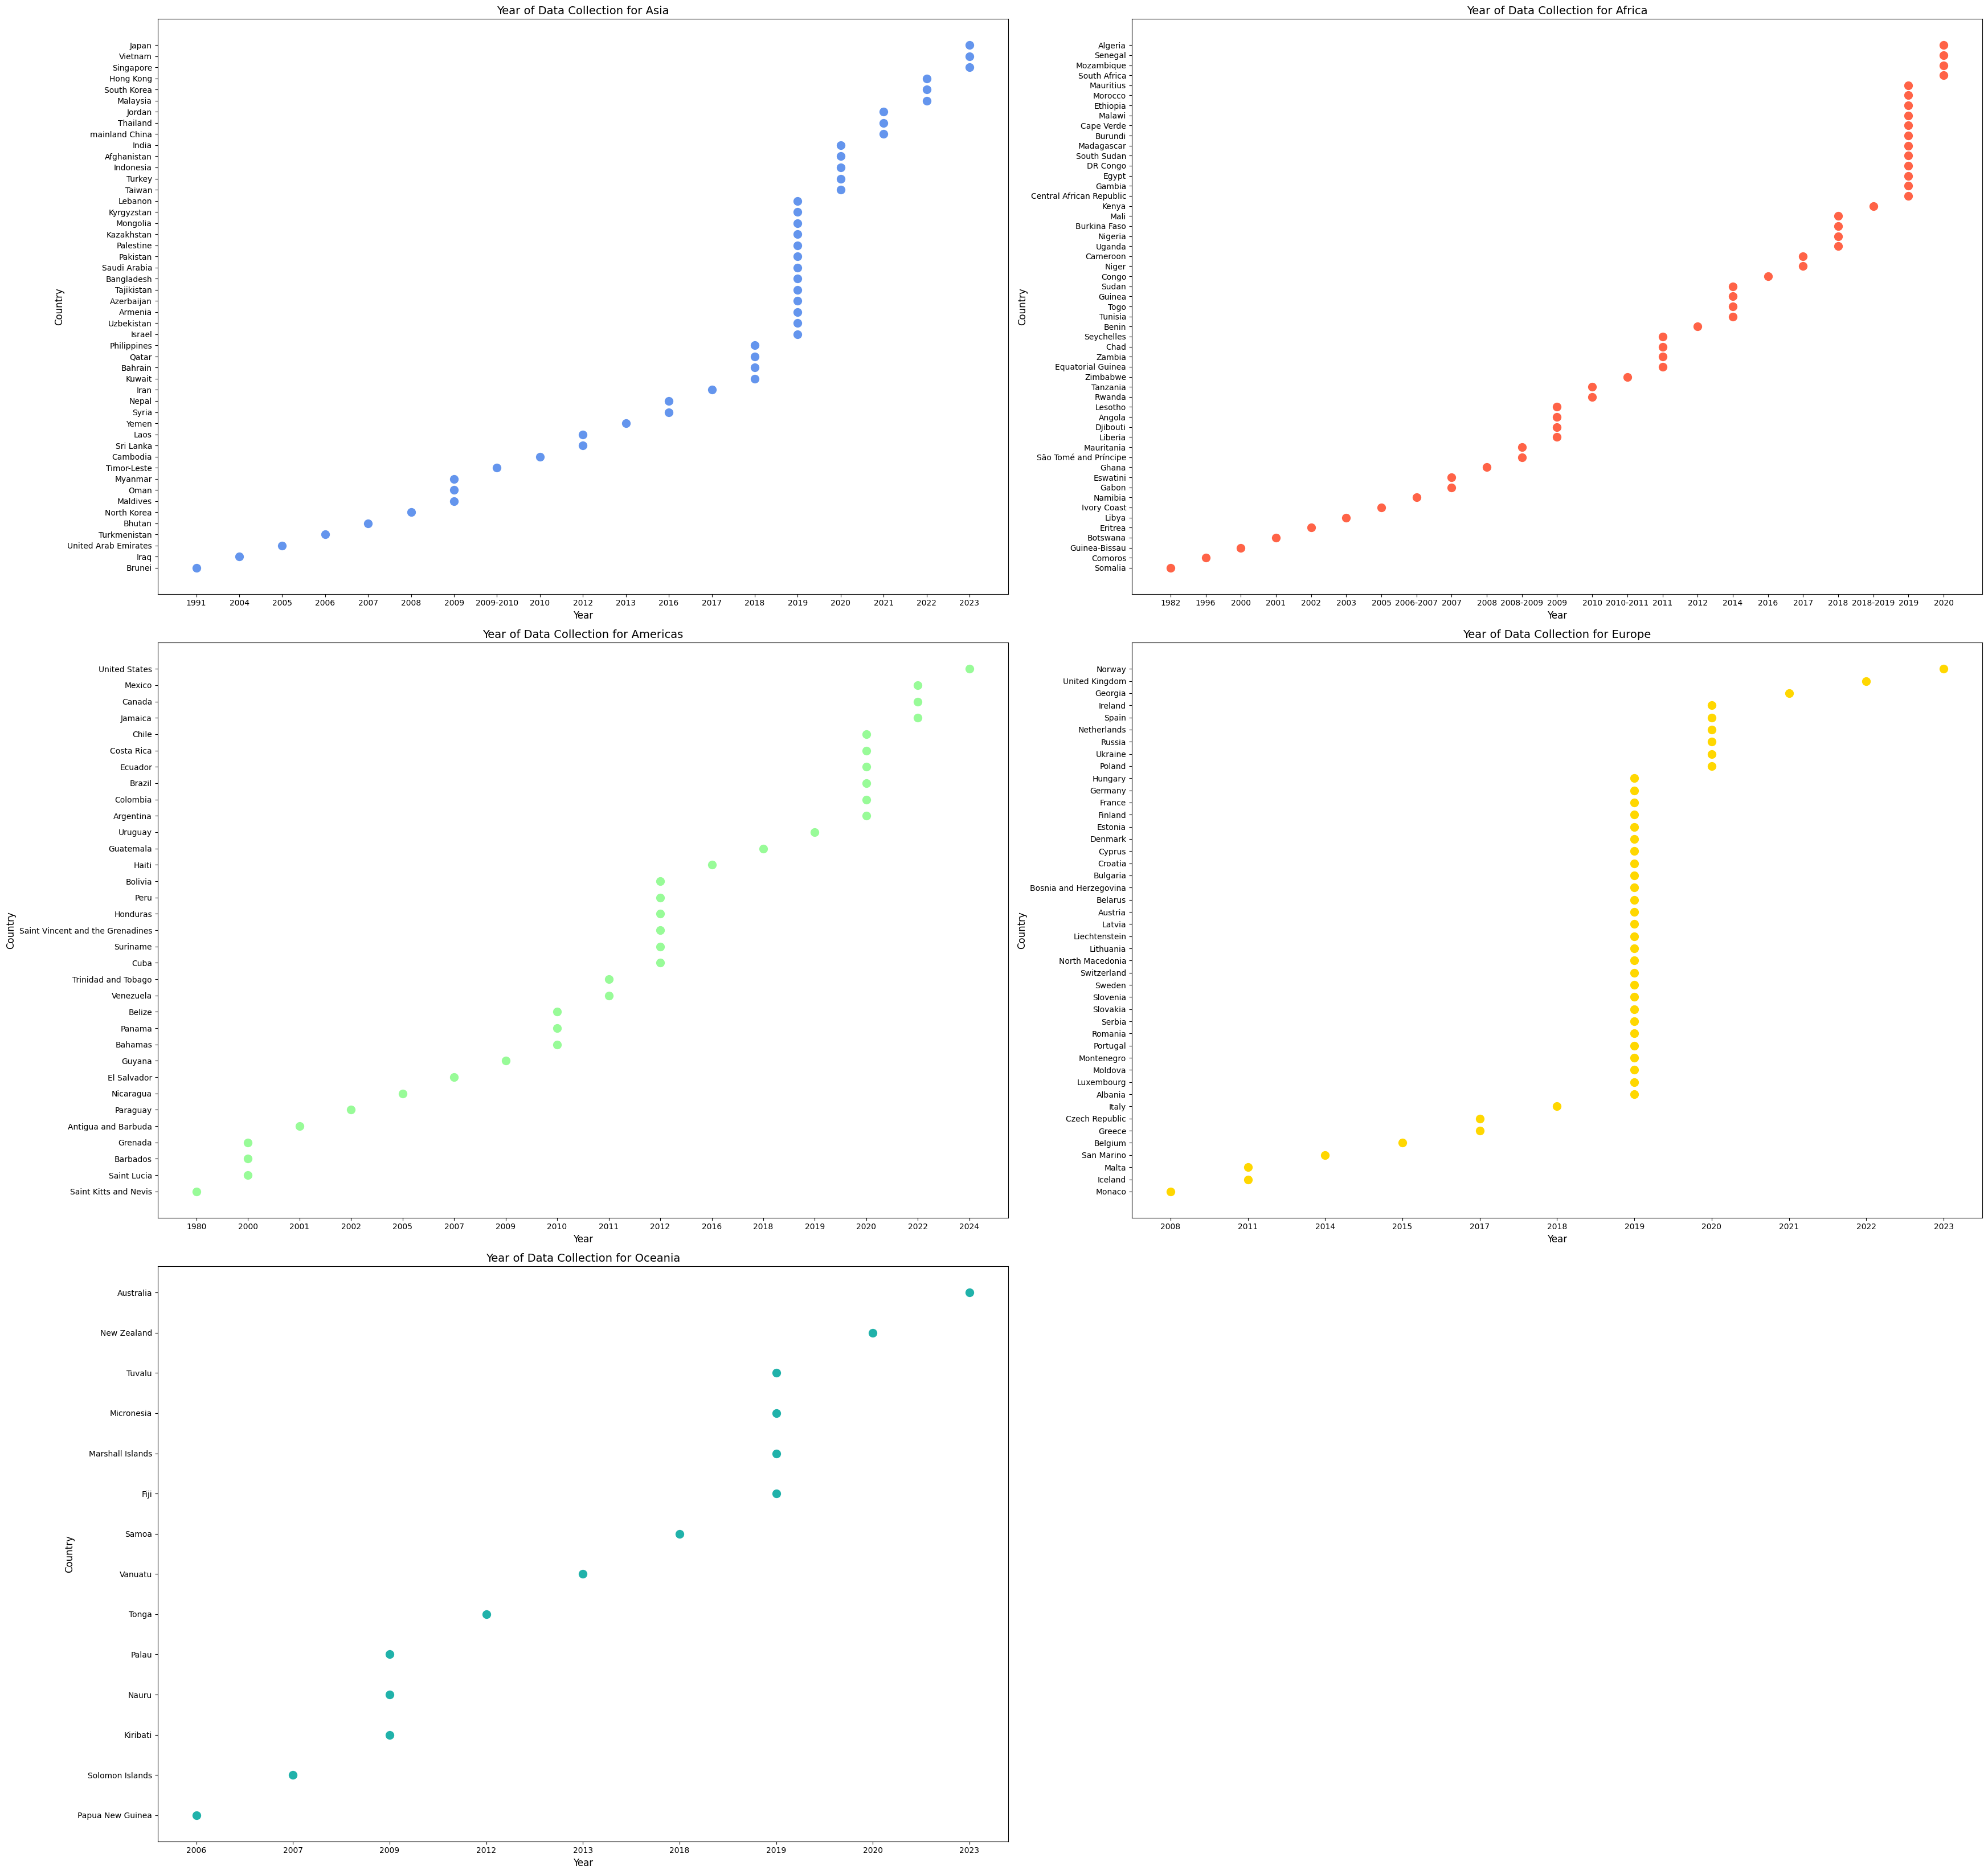

In [27]:

# Sort each DataFrame by 'Year'
df_asia_sorted = pd.DataFrame(continent_data.get('Asia', []))
df_africa_sorted = pd.DataFrame(continent_data.get('Africa', []))
df_americas_sorted = pd.DataFrame(continent_data.get('Americas', []))
df_europe_sorted = pd.DataFrame(continent_data.get('Europe', []))
df_oceania_sorted = pd.DataFrame(continent_data.get('Oceania', []))

# Sort the DataFrames by 'Year'
df_asia_sorted = df_asia_sorted.sort_values(by='Year')
df_africa_sorted = df_africa_sorted.sort_values(by='Year')
df_americas_sorted = df_americas_sorted.sort_values(by='Year')
df_europe_sorted = df_europe_sorted.sort_values(by='Year')
df_oceania_sorted = df_oceania_sorted.sort_values(by='Year')

# Create subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(35, 33))  # 3 rows, 2 columns, increased size

# Asia plot
axes[0, 0].scatter(df_asia_sorted['Year'], df_asia_sorted['Country'], color='#6495ED', s=100)
axes[0, 0].set_title('Year of Data Collection for Asia', fontsize=14)
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Country', fontsize=12)

# Africa plot
axes[0, 1].scatter(df_africa_sorted['Year'], df_africa_sorted['Country'], color='#FF6347', s=100)
axes[0, 1].set_title('Year of Data Collection for Africa', fontsize=14)
axes[0, 1].set_xlabel('Year', fontsize=12)
axes[0, 1].set_ylabel('Country', fontsize=12)

# Americas plot
axes[1, 0].scatter(df_americas_sorted['Year'], df_americas_sorted['Country'], color='#98FB98', s=100)
axes[1, 0].set_title('Year of Data Collection for Americas', fontsize=14)
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Country', fontsize=12)

# Europe plot
axes[1, 1].scatter(df_europe_sorted['Year'], df_europe_sorted['Country'], color='#FFD700', s=100)
axes[1, 1].set_title('Year of Data Collection for Europe', fontsize=14)
axes[1, 1].set_xlabel('Year', fontsize=12)
axes[1, 1].set_ylabel('Country', fontsize=12)

# Oceania plot
axes[2, 0].scatter(df_oceania_sorted['Year'], df_oceania_sorted['Country'], color='#20B2AA', s=100)
axes[2, 0].set_title('Year of Data Collection for Oceania', fontsize=14)
axes[2, 0].set_xlabel('Year', fontsize=12)
axes[2, 0].set_ylabel('Country', fontsize=12)

# Hide the empty subplot in the third row, second column
axes[2, 1].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


### Limitations in Data Collection Years

One of the limitations mentioned earlier in the report is that the data on age at first marriage for the countries in each continent was not collected in the same year. In fact, the data collection years vary significantly between countries, which introduces a considerable challenge to the analysis.

For example, in the Americas, the earliest data was collected in 1980 for Saint Kitts and Nevis, while the most recent data was collected in 2024 for the United States. This variation in data collection years significantly affects the accuracy of the analysis.

### Earliest Data Collection Year for Each Continent

- **Asia**: 1991
- **Africa**: 1982
- **Americas**: 1980
- **Europe**: 2008
- **Oceania**: 2006

This inconsistency further complicates the analysis.

### Insights from the Data

- The number of countries in **Asia** is 48, with 27 (56.25%) having data collected after 2018.
- The number of countries in **Africa** is 53, with 16 (30.19%) having data collected after 2018.
- The number of countries in the **Americas** is 33, with 11 (33.33%) having data collected after 2018.
- The number of countries in **Europe** is 44, with 36 (81.82%) having data collected after 2018.
- The number of countries in **Oceania** is 14, with 6 (42.86%) having data collected after 2018.

### Continent Comparison Based on Data Collection After 2018

- **Europe**: The majority of countries (81.82%) have data collected after 2018, the highest percentage.
- **Asia**: 56.25% of countries have data collected after 2018.
- **Oceania**: 42.86% of countries have data collected after 2018.
- **Americas**: 33.33% of countries have data collected after 2018.
- **Africa**: 30.19% of countries have data collected after 2018, the lowest percentage.

In terms of the **majority** of countries with data collected after 2018, **Europe** leads with the highest percentage, followed by **Asia**. The **Americas** and **Africa** have relatively lower percentages, with **Africa** having the smallest proportion of countries with recent data.


# Summary:
This project investigates the "Age at First Marriage" across Asian countries, with a focus on gender differences and comparisons with global data. It provides a detailed statistical analysis, including mean, median, mode, standard deviation, and variance of the age at first marriage within Asia. The study further explores gender disparities by comparing the average age at first marriage for men and women. The project also expands its analysis by comparing Asia's data with other continents, taking into account the global rankings of countries based on age at first marriage, and exploring how the year of data collection might affect trends.

## Conclusion:
The findings of this project provide valuable insights into marriage trends within Asia, highlighting the differences in marriage ages between men and women and comparing these trends with other regions worldwide. The statistical analysis, alongside the gender-based and global comparisons, helps to identify patterns that may be influenced by cultural, social, and economic factors. While limitations such as missing data, discrepancies in data collection timeframes, and varying data collection methodologies must be acknowledged, the analysis provides a solid foundation for understanding how the age at first marriage varies across countries. This study could serve as a basis for further research into the factors influencing marriage age, offering a broader view of societal trends both in Asia and globally.


**Summary: Age at First Marriage in Asia and Global Comparisons**

| **Metric**                     | **Men**     | **Women**   | **Overall** |
|--------------------------------|-------------|-------------|-------------|
| Mean Age                       | 28.69 years | 25.68 years | 27.20 years |
| Most Frequent Age (Mode)        | 27.2 years  | 21.0 years  | -           |
| Median Age                      | 28.6 years  | 25.45 years | -           |
| Standard Deviation              | 3.20        | 3.42        | -           |
| Variance                        | 10.23       | 11.71       | -           |




| **Category**                    | **Key Finding**                                              |
|---------------------------------|-------------------------------------------------------------|
| Highest Average Age             | South Korea (38 years), Lebanon (32.4 years)                 |
| Lowest Average Age              | Nepal, Laos (21.9 years)                                     |
| Largest Age Gap                 | Syria (>5 years)                                             |
| Smallest Age Gap                | Singapore (<1 year)                                          |
| Common Age Gaps                 | Multiple countries share similar gaps (1.6 to 4.4 years)     |
| Global Rank in Mean Age         | 3rd (higher than Africa, Oceania; lower than Europe, Americas) |
| Global Rank in Age Gap          | Moderate (higher than Europe, Americas, Oceania; lower than Africa) |




- **Lowest Age**: Laos/Nepal (21.9 years), 6th lowest globally, reflecting younger marriage trends due to cultural or economic factors.
- **Highest Age**: South Korea (38 years), 4th highest globally, indicating delayed marriages influenced by urbanization, career, and education.


   **Data Notes**
- **Year Range**: 1991 to 2023, mostly post-2019.
- **Impact**: Variations in data collection years may affect comparability.


# References and Resources¶
## References

[1] Wikipedia. List of countries by age at first marriage [Online]. Available: https://en.wikipedia.org/wiki/List_of_countries_by_age_at_first_marriage

[2] Koreapro. Tying the knot or not: South Korea’s trend of delayed marriage registration [Online]. Available: https://koreapro.org/2024/07/tying-the-knot-or-not-south-koreas-trend-of-delayed-marriage-registration/

## Resources Used

### Web Scraping

- Alyx the Analyst. *Scraping Data from a Real Website | Web Scraping in Python* [Online Video]. Available: [https://www.youtube.com/watch?v=8dTpNajxaH0&t=372s](https://www.youtube.com/watch?v=8dTpNajxaH0&t=372s)
- Web Scraping Lecture, Llewelyn Fernandes, University of London, Coursera, Module CM2015, [Online Video]. Available: https://coursera.org/learn/uol-cm2015-programming-with-data/lecture/x7Uhx/5-13-webscraping-and-apis-with-llewelyn-fernandes
- Journalistic Voice Report, University of London, Coursera, Module CM2015 (used as a format guide for the report)



### Data Cleaning and Processing, Feature Generation

- Alyx the Analyst. *Data Cleaning in Pandas | Python Pandas Tutorials* [Online Video]. Available: [https://www.youtube.com/watch?v=bDhvCp3_lYw](https://www.youtube.com/watch?v=bDhvCp3_lYw)
- *Cleaning a Dataset and Removing Special Characters in Python*, Stack Overflow. Available: [https://stackoverflow.com/questions/63904201/cleaning-a-dataset-and-removing-special-characters-in-python](https://stackoverflow.com/questions/63904201/cleaning-a-dataset-and-removing-special-characters-in-python)
- *Remove Special Characters from String in Python*, GeeksforGeeks. Available: [https://www.geeksforgeeks.org/python-removing-unwanted-characters-from-string/](https://www.geeksforgeeks.org/python-removing-unwanted-characters-from-string/)

### Exploratory Data Analysis

- Zach. *How to Change Legend Font Size in Matplotlib* [Online]. Available: [https://www.statology.org/matplotlib-legend-font-size/](https://www.statology.org/matplotlib-legend-font-size/)
- *Data Plotting*, Llewelyn Fernandes Lecture, University of London, Coursera [Online Video]. Available: [Coursera Link](https://www.coursera.org/learn/uol-cm2015-programming-with-data/lecture/Mw4VE/guest-lecture-with-llewelyn-fernandes-data-plotting)
- *Bar Plot in Matplotlib*, GeeksforGeeks. Available: [https://www.geeksforgeeks.org/bar-plot-in-matplotlib/](https://www.geeksforgeeks.org/bar-plot-in-matplotlib/)
- Keith Galli. *Intro to Data Visualization in Python with Matplotlib!* [Online Video]. Available: [https://www.youtube.com/watch?v=DAQNHzOcO5A](https://www.youtube.com/watch?v=DAQNHzOcO5A)
- *Trying to Add Color Gradients to Matplotlib Chart*, Stack Overflow. Available: [https://stackoverflow.com/questions/50768544/trying-to-add-color-gradients-to-matplotlib-chart](https://stackoverflow.com/questions/50768544/trying-to-add-color-gradients-to-matplotlib-chart)
- *Line chart, Python & Matplotlib examples*, Python Graph Gallery [Online Video]. Available: [Python Graph Gallery](https://python-graph-gallery.com/line-chart/#:~:text=A%20line%20chart%20displays%20the,plotly%20allow%20to%20build%20it.)